To run this example notebook:
* pandas, numy, biopython are needed for this notebook.
* viruses model files and lshvec java library are required to be downloaded (refer to project README)
* install PyLSHVec (pip, docker or from code)
* Be warning that jnius may not work on your environment. Refer to https://github.com/kivy/pyjnius for trouble shooting.

In [1]:
%pylab inline
import sys,os
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
if 0: #ignore this
    sys.path.insert(0,"../src/")
    os.environ['JAVA_HOME']='/usr/lib/jvm/java-openjdk/'

In [5]:
from pylshvec import *

In [6]:
#here needs jlshvec jar file, download it first
set_lshvec_jar_path("/mnt/jlshvec-assembly-0.1.jar")

In [7]:
#since vector model is usually large, set a big java memory limit is preferred. 
add_java_options("-Xmx32G")

In [8]:
#here need model file and lsh function file, download them first
model= LSHVec(model_file="/mnt/refdb_viruses_model_gs_k23_l3000_rand_m299", hash_file="/mnt/lsh_nt_NonEukaryota_k23_h25.crp")

In [9]:
#use help to see the methods
help(model)

Help on LSHVec in module pylshvec.lshvec object:

class LSHVec(builtins.object)
 |  LSHVec(model_file, hash_file, threshold=0.005, max_results=500, batch_size=1024, num_thread=1, only_show_main_tax=False, without_uncult=True)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_file, hash_file, threshold=0.005, max_results=500, batch_size=1024, num_thread=1, only_show_main_tax=False, without_uncult=True)
 |      load a pre-trained lshvec model. 
 |      
 |      Parameters:
 |          model_file: pre-trained model file, which contains k-mer vectors and model parameters
 |          hash_file: lsh hash function file
 |      
 |      Refer to get methods for the meaning of other parameters
 |  
 |  embedding(self, seq_or_seqs)
 |      Get the embedding vector/vectors for a sequence or a list of sequence (multiple threads if #thread > 1)
 |  
 |  embedding_single_thread(self, seq_or_seqs)
 |      Get the embedding vector/vectors for a sequence or a list of sequence (single thread 

In [9]:
#To show some parameters
getIgnores = ['getRank', 'getName', 'getTaxIdPath', 'getTaxNamePath']
for u in dir(model):
    if not u in getIgnores:
        if u.startswith('get') or u.startswith('is'):
            fun = getattr(model, u)
            print(u, fun())

getBatchsize 1024
getKmerSize 23
getMaxItems 500
getNumThread 1
getThreshold 0.004999999888241291
getVecDim 100
isInitialized True
isOnlyShowLeaf False
isOnlyShowMainTax True
isWithoutUncult True


In [12]:
#to show information for a taxonomy id
# All taxonomiy ids are ncbi taxonomy ids, except dummy id which is not less than 4000000
for u in getIgnores:
    fun = getattr(model, u)
    print(u, fun(1980526))

getRank species
getName Nairobi sheep disease orthonairovirus
getTaxIdPath [1, 10239, 4000001, 4011699, 4027768, 4027770, 4027773, 2559587, 4028110, 4028113, 4032822, 4032824, 4032826, 2497569, 4032829, 2497571, 2497576, 1980410, 4034803, 4035699, 4035703, 1980415, 4036275, 1980517, 4036277, 4036320, 4036323]
getTaxNamePath ['root', 'Viruses', 'dummy4000001', 'dummy4011699', 'dummy4027768', 'dummy4027770', 'dummy4027773', 'Riboviria', 'dummy4028110', 'dummy4028113', 'dummy4032822', 'dummy4032824', 'dummy4032826', 'Negarnaviricota', 'dummy4032829', 'Polyploviricotina', 'Ellioviricetes', 'Bunyavirales', 'dummy4034803', 'dummy4035699', 'dummy4035703', 'Nairoviridae', 'dummy4036275', 'Orthonairovirus', 'dummy4036277', 'dummy4036320', 'dummy4036323']


In [19]:
def random_dna_sequence(length):
    return ''.join(np.random.choice(list('ACTG')) for _ in range(length))

def add_substitute_error(seq, err_rate=0.05):
    return "".join(    np.random.choice(list('ACTG'))  if np.random.random()<err_rate else u for u in seq )
def random_sub_seq(seq,length=500):
    assert len(seq)>length
    i=int(np.random.random()*(len(seq)-length))
    return seq[i:i+length]
def predict(seq):
    pred=pd.Series(model.predict(seq), name='prob')
    pred.index.name='taxid'
    pred=pred.to_frame()
    pred['rank']=pred.index.map(lambda u: model.getRank(u))
    pred['name']=pred.index.map(lambda u: model.getName(u))
    return pred.sort_values("prob",ascending=False)

### let's play with an assembly  for (Nairobi sheep disease virus)[https://www.ncbi.nlm.nih.gov/assembly/GCF_002117695.1/] whose taxid is 194540.

In [14]:
url="ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/002/117/695/GCA_002117695.1_ViralMultiSegProj384967/GCA_002117695.1_ViralMultiSegProj384967_genomic.fna.gz"

In [15]:
#download the sequence
import urllib 
from Bio import SeqIO
import gzip
with  urllib.request.urlopen(url) as handle_url :
    with gzip.open(handle_url, 'rt') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            print(record.id, len(record))
            break

KM464726.1 12081


In [17]:
seq=str(record.seq)
print ("The sequence length is {}".format(len(seq)))

The sequence length is 12081


##### Look at how the model predict on the whole seq

In [20]:
predict(seq)

,prob,rank,name
taxid,,,
1980410,1.0001,order,Bunyavirales
2497569,1.0001,phylum,Negarnaviricota
2497576,1.0001,class,Ellioviricetes
10239,1.0000,superkingdom,Viruses
1980415,0.9995,family,Nairoviridae
1980517,0.9995,genus,Orthonairovirus
1980526,0.9903,species,Nairobi sheep disease orthonairovirus
1980527,0.0055,species,Qalyub orthonairovirus


### While, it gives a probability of 0.99 on 1980526, which is good. 

### How about introducing errors? I only randomly introduce substituting errors in this notebook (More realistic errors untilize error profile/distribution which is too complex here.).  For example for err rate 3%, the probabily for 1980526 becomes 80+%.

In [25]:
predict(add_substitute_error(seq,0.03)).head(15)

,prob,rank,name
taxid,,,
10239,1.0000,superkingdom,Viruses
2497569,0.9845,phylum,Negarnaviricota
2497576,0.9836,class,Ellioviricetes
1980410,0.9836,order,Bunyavirales
1980517,0.8905,genus,Orthonairovirus
1980415,0.8905,family,Nairoviridae
1980526,0.8207,species,Nairobi sheep disease orthonairovirus
11617,0.0516,family,Arenaviridae
1653394,0.0497,genus,Mammarenavirus


### Let's do 20 times for each error rate and show the accuracy of correctly predicting 1980526

In [49]:
def mean_prob_with_error(seq, error_rate=0.01, target_taxid=1980526):
    count=0.0
    for i in range(20):
        pred = predict(add_substitute_error(seq, error_rate))
        species_pred_df = pred[pred['rank']=="species"]
        if(len(species_pred_df)==0):
            pass
        else:
            
            taxid= species_pred_df.iloc[0].name
            if target_taxid ==taxid:
                count+=1
            else:
                pass
    return count/20


In [50]:
err_rates =np.arange(0.01,0.10,0.01)
acc=[mean_prob_with_error(seq,x) for x in err_rates]

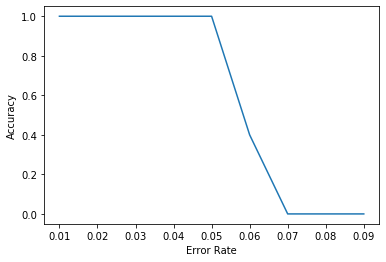

In [62]:
plt.plot(err_rates,acc)
plt.xlabel("Error Rate")
plt.ylabel("Accuracy");

### All the above work on the whole sequence. How about for sub sequences?

In [57]:
predict(random_sub_seq(seq,300))

,prob,rank,name
taxid,,,
1980410,1.0001,order,Bunyavirales
2497569,1.0001,phylum,Negarnaviricota
2497576,1.0001,class,Ellioviricetes
10239,1.0000,superkingdom,Viruses
1980415,0.9979,family,Nairoviridae
1980517,0.9979,genus,Orthonairovirus
1980526,0.9877,species,Nairobi sheep disease orthonairovirus


### It is not bad for a 300-length sequence.

### We are going to show the mean prediction probabilities for tax 1980526 for various subseq length.

In [63]:
def mean_prob(seq_len=500, target_taxid=1980526):
    prob_list=[]
    for i in range(0,len(seq)-seq_len,int(seq_len/4)):
        aseq = seq[i:i+seq_len]
        pred = model.predict(aseq)
        if target_taxid in pred:
            prob_list.append(pred[target_taxid])
        else:
            prob_list.append(0)
    return np.mean(prob_list)


In [64]:
lengths =list( range(100,1000,25))
probs=[mean_prob(seq_len=u) for u in lengths]

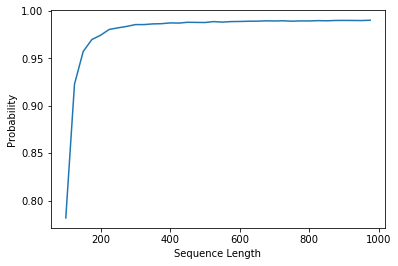

In [67]:
plt.plot(lengths,probs)
plt.ylabel("Probability")
plt.xlabel("Sequence Length");